
## Paquetería necesaria


In [114]:
##Borrar datos del entorno
rm(list=ls())


#Se utiliza pacman para instalar y cargar paquetes
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,janitor,webshot2,rmapshaper,
               showtext,sf, httr,jsonlite,gt,ggrepel,magick,gt, lubridate)
#Fuente para los gráficos
font_add_google("Montserrat", "pop")
showtext_auto()

### Funciones

In [115]:
#Función para consultar la api

consulta_api<-function(url){
  r <- GET(url, timeout(10000))
  df <- fromJSON(rawToChar(r$content))
  return(df)
}

In [116]:
crea_grafbarra <- function(data, group_var_1,group_var_2,texto_x,texto_y,titulo_grafica,subtitulo,texto_fuente, titulo_leyenda) {
  colores <- c("#235b4e", "#bc955c", "#98989a", "#9f2241", "#ddc9a3", "#6A8EAE", "#333333")

  
  # Prepare the data
  processed_data <- data %>%
    group_by({{group_var_1}}, {{ group_var_2 }}) %>%
    summarise(acciones = sum(creditos, na.rm = TRUE), monto = sum(monto, na.rm = TRUE)) %>%
    ungroup() %>%
    group_by({{group_var_1}}) %>%
    mutate(porcentaje = round(acciones / sum(acciones) * 100, 1)) %>%
    ungroup()
  
  # Create the bar chart with the processed data
  p <- ggplot(processed_data, aes(x = as.factor({{group_var_1}}), y = porcentaje, fill = {{ group_var_2}})) + 
    geom_bar(stat = "identity", position = position_dodge(width = 0.9), width=0.8) +
    geom_text(aes(label = porcentaje), vjust = -0.5, position = position_dodge(width = 0.9), size = 7) +
    scale_fill_manual(name=titulo_leyenda,values = colores) +
     labs(x = texto_x, y = texto_y, title = titulo_grafica, subtitle = subtitulo,
          caption = texto_fuente,fill = as.character(rlang::as_label(rlang::enquo(group_var_2))))+
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0, size = 20, face = "bold"),
      plot.subtitle = element_text(hjust = 0, size = 15, face = "italic"),
      plot.caption = element_text(hjust = 0, size = 10),
      legend.position = "right",
      axis.ticks = element_blank(),
      axis.title = element_text(size = 15),
      axis.text.x = element_text(size = 12, angle = 0, hjust = 0.5, vjust = 0.2),
      axis.text.y = element_text(size = 12),
      text = element_text(family = "pop"),
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 12)
    )
  
  return(p)
}

In [117]:

#Función para crear tabla
crea_tabla <- function(df, titulo, subtitulo,nota="",nombre_archivo){

  # Format the numeric columns with commas
  formatted_df <- df %>%
    mutate(across(where(is.numeric), ~scales::comma(.)))

  # Checa si existe la columna "Organismo" para agrupar la tabla
  if("Organismo" %in% names(df)) {
    gt_table <- formatted_df %>%
      gt(rowname_col = "Organismo",
         groupname_col = "Año",
         row_group_as_column = TRUE)
  } else {
    gt_table <- formatted_df %>%
      gt()
  }

  gt_table <- gt_table %>%
    tab_options(
      column_labels.font.weight = "bold",
    ) %>%
    tab_header(
      title = md(paste0("**", titulo, "**")),
      subtitle=md(paste0("*", subtitulo, "*"))
    ) %>%
    tab_options(
      table.font.names = 'Poppins',
      source_notes.font.size = 8,
      table.border.top.width = px(0),
      table.border.bottom.width = px(0),
      column_labels.background.color = "#235b4eff",
      column_labels.font.size = 10,
    heading.title.font.size = 15,
    ) %>%
    cols_align(
      align = "center"
    ) %>%
    tab_source_note(
      source_note = md("Nota: Cifras preliminares.")
    ) %>%
    tab_source_note(
      source_note = md(nota)
    ) %>%
    tab_source_note(
      source_note = md("Fuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con información del Sistema Nacional de Información e Indicadores de Vivienda (SNIIV).")
    )%>%
    cols_width(
      everything() ~ px(160)
    )

  # Salva la tabla
  gtsave(gt_table, filename = nombre_archivo)

  # Muestra la imagen
  img <- image_read(nombre_archivo)
  return(img)
}


In [118]:
paleta<-c("#691c32ff", "#901d3dff","#ac2540ff","#c88f80ff","#e3c8a6ff")
paleta_mapa<- c("#7e5f33","#a27b42","#bc955c","#caac80","#d9c4a4")
colores <- c("#235b4e", "#bc955c", "#98989a", "#9f2241", "#ddc9a3", "#6A8EAE", "#333333")

## Descarga y limpieza de datos

In [119]:
urlfin<-"https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2018,2023/0/0/organismo,anio,destino_credito,rango_salarial,rango_edad,estado,modalidad"

In [120]:
financiamientos <-consulta_api(urlfin)%>%
#Filtrar estados requeridos
filter(estado=="Tlaxcala" | estado=="Guerrero"  | estado=="Campeche" | estado=="Oaxaca" | estado=="Yucatán")%>%
#Filtro de INFONAVIT y FOVISSSTE
filter(organismo=="INFONAVIT" | organismo=="FOVISSSTE")
financiamientos

año,estado,organismo,modalidad,destino_credito,grupo_edad,rango_salarial,acciones,monto
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
2018,Campeche,FOVISSSTE,Viviendas nuevas,Vivienda nueva,29 o menos,2.6 o menos,1,415805.4
2018,Guerrero,FOVISSSTE,Viviendas nuevas,Vivienda nueva,29 o menos,2.6 o menos,1,420984.1
2018,Oaxaca,FOVISSSTE,Viviendas nuevas,Vivienda nueva,29 o menos,2.6 o menos,2,839543.4
2018,Yucatán,FOVISSSTE,Viviendas nuevas,Vivienda nueva,29 o menos,2.6 o menos,12,4244545.0
2018,Guerrero,FOVISSSTE,Viviendas nuevas,Vivienda nueva,30 a 59,2.6 o menos,41,16400293.1
2018,Oaxaca,FOVISSSTE,Viviendas nuevas,Vivienda nueva,30 a 59,2.6 o menos,10,4200807.3
2018,Tlaxcala,FOVISSSTE,Viviendas nuevas,Vivienda nueva,30 a 59,2.6 o menos,7,2854776.2
2018,Yucatán,FOVISSSTE,Viviendas nuevas,Vivienda nueva,30 a 59,2.6 o menos,14,5545688.1
2018,Guerrero,FOVISSSTE,Viviendas nuevas,Vivienda nueva,60 o más,2.6 o menos,3,1421156.5


In [121]:
unique(financiamientos$estado)

[1] "Campeche" "Guerrero" "Oaxaca"   "Yucatán"  "Tlaxcala"

### Resultados

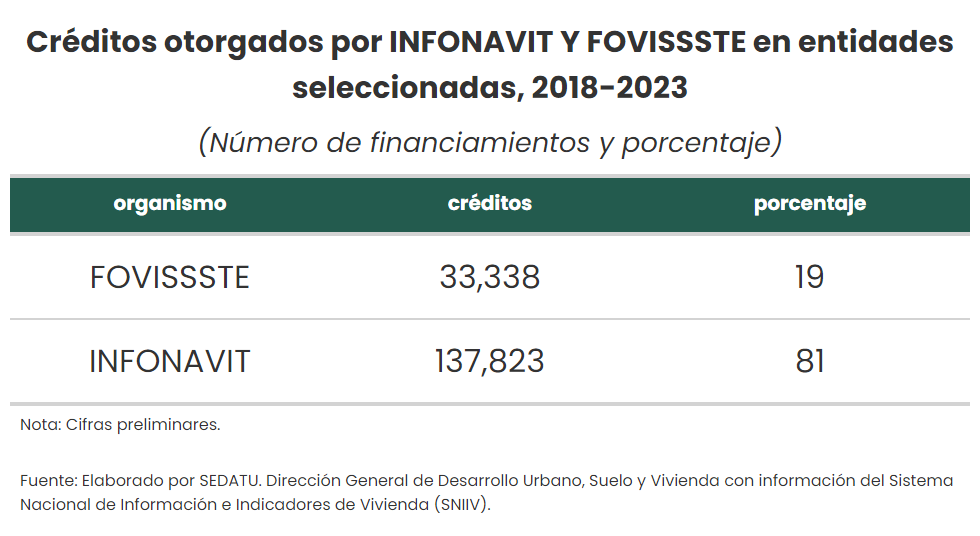

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      980    536 sRGB       FALSE    49180 72x72  

In [122]:
financiamientos%>%
group_by(organismo)%>%
summarise(creditos=sum(acciones))%>%
mutate(pct=creditos/sum(creditos)*100)%>%
rename("créditos"=creditos,"porcentaje"=pct)%>%
ungroup()%>%
crea_tabla(titulo="Créditos otorgados por INFONAVIT Y FOVISSSTE en entidades seleccionadas, 2018-2023",subtitulo="(Número de financiamientos y porcentaje)",nota="",nombre_archivo="fin_organismo.png")


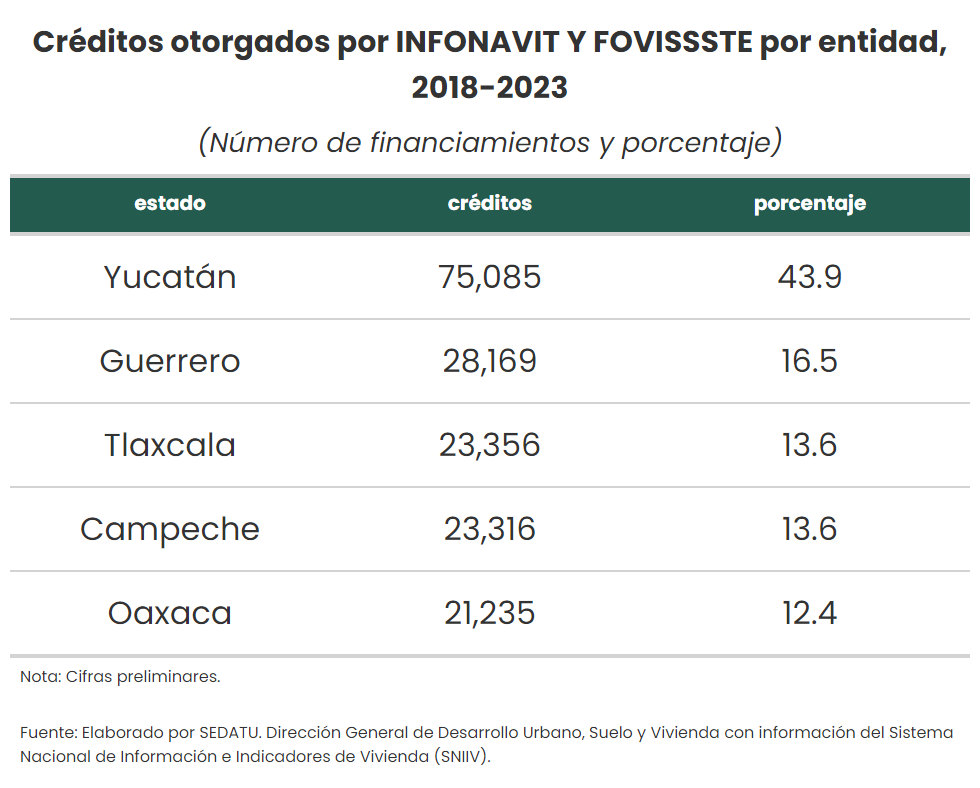

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      980    788 sRGB       FALSE    64669 72x72  

In [123]:
financiamientos%>%
group_by(estado)%>%
summarise(creditos=sum(acciones))%>%
mutate(pct=round(creditos/sum(creditos)*100,1))%>%
#Ordenar de mayor a menor
arrange(desc(creditos))%>%
rename("créditos"=creditos,"porcentaje"=pct)%>%
ungroup()%>%
crea_tabla(titulo="Créditos otorgados por INFONAVIT Y FOVISSSTE por entidad, 2018-2023",subtitulo="(Número de financiamientos y porcentaje)",nota="",nombre_archivo="fin_estado.png")


`summarise()` has grouped output by 'estado'. You can override using the
`.groups` argument.


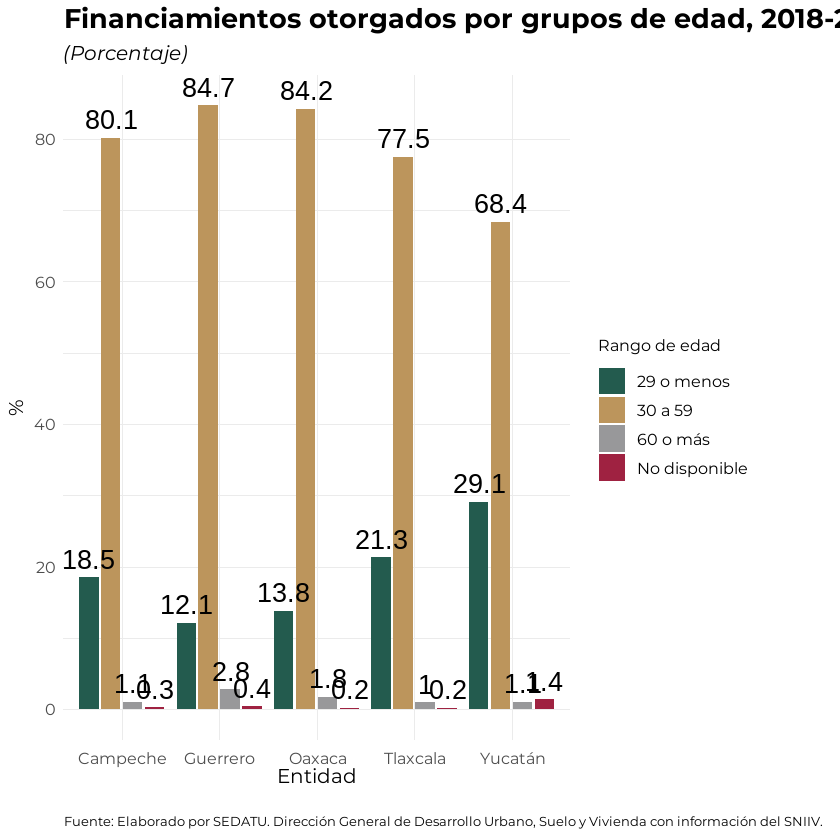

In [124]:
financiamientos%>%
rename("creditos"=acciones)%>%
crea_grafbarra(estado,grupo_edad,"Entidad","%","Financiamientos otorgados por grupos de edad, 2018-2023","(Porcentaje)", 
               "\nFuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con información del SNIIV.",
               "Rango de edad")

ggsave("estados_rango_edad.png",width = 10, height = 7, units = "in", dpi = 150,bg= "white")

`summarise()` has grouped output by 'año', 'grupo_edad'. You can override using
the `.groups` argument.


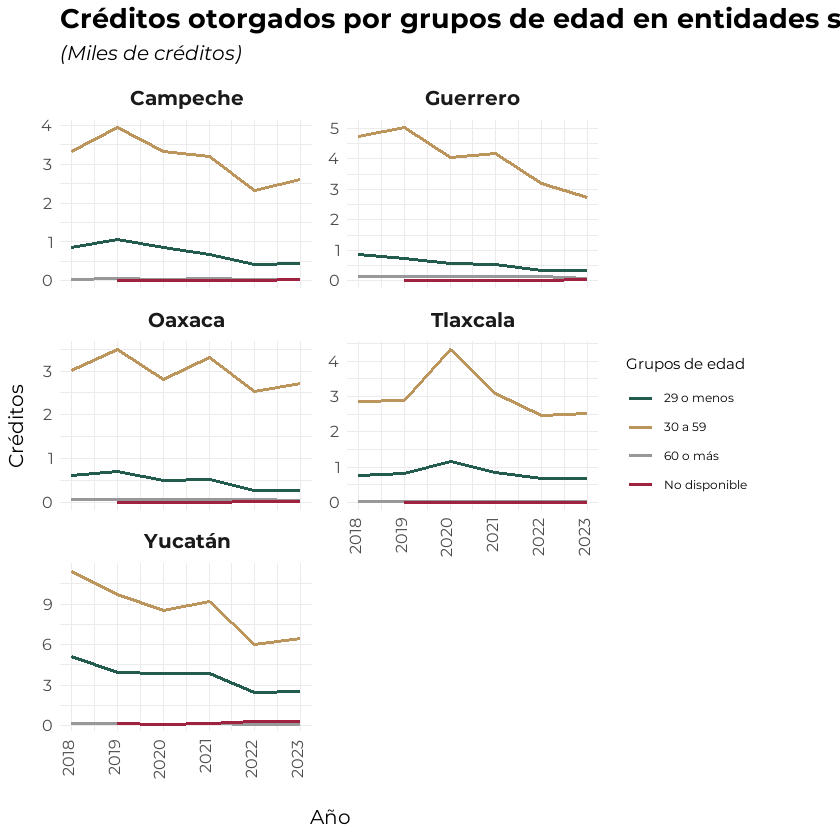

In [125]:
financiamientos%>%
group_by(año,grupo_edad,estado)%>%
summarise(creditos=sum(acciones))%>%
mutate(creditos=creditos/1000)%>%
ungroup()%>%
ggplot(aes(x=año,y=creditos,color=grupo_edad))+
geom_line(aes(group=grupo_edad),size=1)+
scale_color_manual("Grupos de edad",values=colores)+
labs(x="Año",y="Créditos",title="Créditos otorgados por grupos de edad en entidades seleccionadas, 2018-2023",subtitle="(Miles de créditos)",fill="Rango de edad")+
theme_minimal()+
theme(legend.position = "bottom")+
scale_y_continuous(labels = scales::label_comma()) +
    theme(
      plot.title = element_text(hjust = 0, size = 20, face = "bold"),
      plot.subtitle = element_text(hjust = 0, size = 15, face = "italic"),
      plot.caption = element_text(hjust = 0, size = 8),
      legend.position = "right",
      axis.ticks = element_blank(),
      axis.title = element_text(size = 15),
      axis.text.x = element_text(size = 12, angle = 90, hjust = 0.95, vjust = 0.2),
      axis.text.y = element_text(size = 12),
      text = element_text(family = "pop"),
      strip.text = element_text(size = 15,face = "bold")
    )+
facet_wrap(~estado,ncol=2, scales = "free_y")

ggsave("linea_organismo.png",width = 10, height = 7, units = "in", dpi = 150,bg= "white")


`summarise()` has grouped output by 'año', 'organismo'. You can override using
the `.groups` argument.


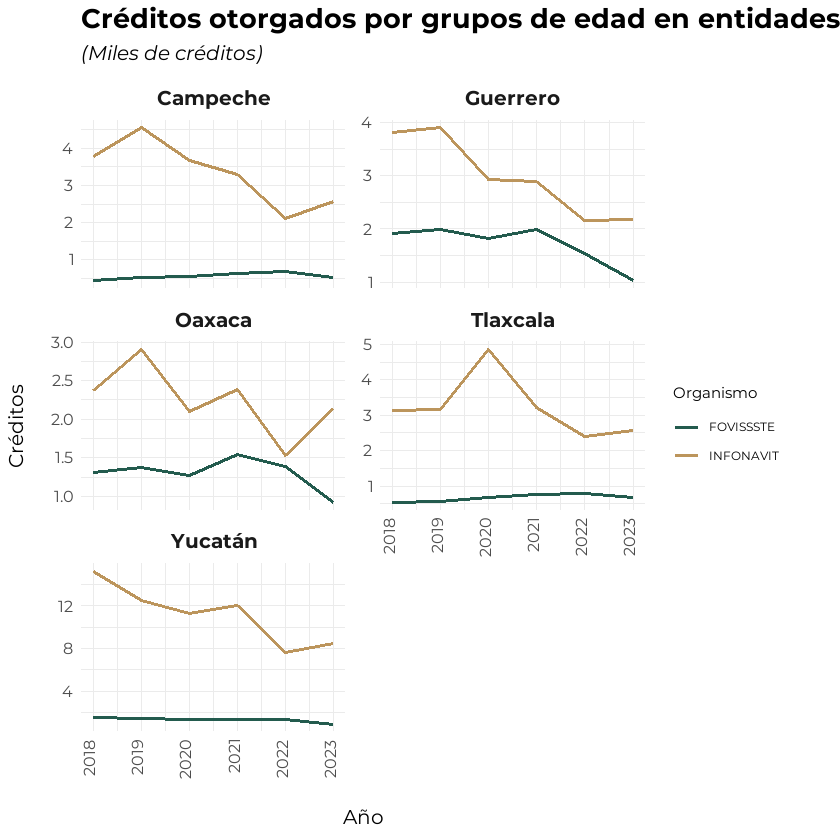

In [126]:
financiamientos%>%
group_by(año,organismo,estado)%>%
summarise(creditos=sum(acciones))%>%
mutate(creditos=creditos/1000)%>%
ungroup()%>%
ggplot(aes(x=año,y=creditos,color=organismo))+
geom_line(aes(group=organismo),size=1)+
scale_color_manual("Organismo",values=colores)+
labs(x="Año",y="Créditos",title="Créditos otorgados por grupos de edad en entidades seleccionadas, 2018-2023",subtitle="(Miles de créditos)",fill="Rango de edad")+
theme_minimal()+
theme(legend.position = "bottom")+
scale_y_continuous(labels = scales::label_comma()) +
    theme(
      plot.title = element_text(hjust = 0, size = 20, face = "bold"),
      plot.subtitle = element_text(hjust = 0, size = 15, face = "italic"),
      plot.caption = element_text(hjust = 0, size = 8),
      legend.position = "right",
      axis.ticks = element_blank(),
      axis.title = element_text(size = 15),
      axis.text.x = element_text(size = 12, angle = 90, hjust = 0.95, vjust = 0.2),
      axis.text.y = element_text(size = 12),
      text = element_text(family = "pop"),
      strip.text = element_text(size = 15,face = "bold")
    )+
facet_wrap(~estado,ncol=2, scales = "free_y")

ggsave("linea_organismo.png",width = 10, height = 7, units = "in", dpi = 150,bg= "white")


`summarise()` has grouped output by 'estado', 'grupo_edad'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'grupo_edad'. You can override using the
`.groups` argument.


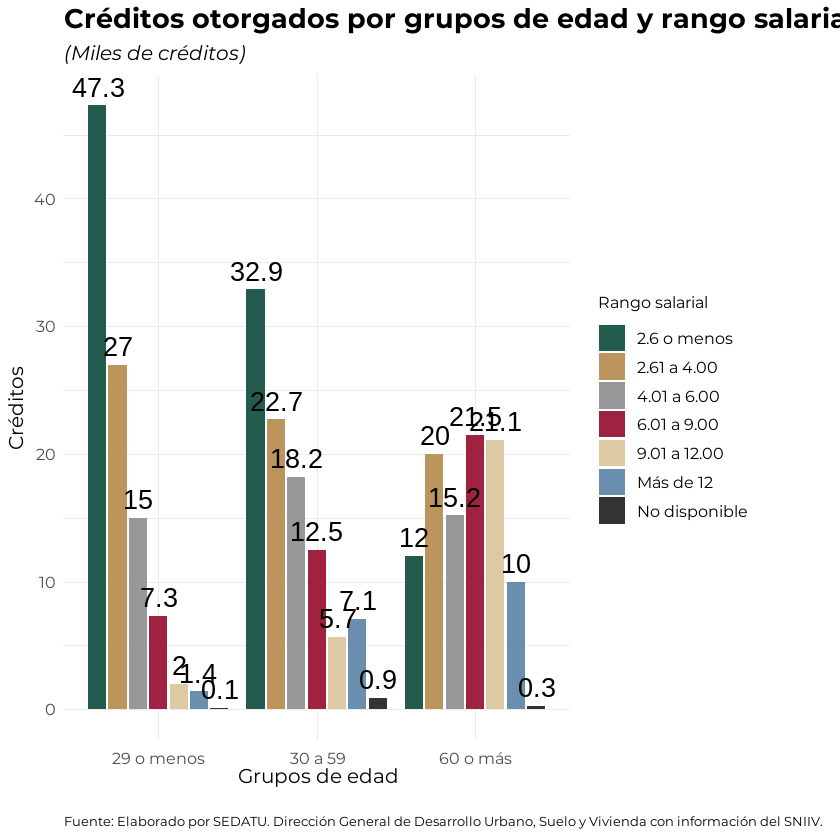

In [127]:
financiamientos%>%
group_by(estado,grupo_edad,rango_salarial)%>%
summarise(creditos=sum(acciones),monto=sum(monto))%>%
mutate(creditos=creditos/1000)%>%
#Eliminar No disponible
filter(grupo_edad!="No disponible")%>%
ungroup()%>%
crea_grafbarra(grupo_edad,rango_salarial,"Grupos de edad","Créditos","Créditos otorgados por grupos de edad y rango salarial, 2018-2023","(Miles de créditos)", 
               "\nFuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con información del SNIIV.",
               "Rango salarial")

ggsave("estados_rango_sal_edad.png",width = 10, height = 7, units = "in", dpi = 150,bg= "white")